In [3]:
import xgboost as xgb
import pandas as pd

In [5]:
datatrain=pd.read_csv('data/hasilsteming3.csv')
datatrain=datatrain[0:4800]
datatrain.sentiment[datatrain.sentiment==0]='net'
datatrain.sentiment[datatrain.sentiment==1]='pos'
datatrain.sentiment[datatrain.sentiment==-1]='neg'
datatrain.head()
len(datatrain)

4800

In [6]:
#from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = TfidfVectorizer(min_df=1,ngram_range=(1,2))
#X_train_tfidf=vectorizer.fit_transform(datatrain['tweetText'])
#X_train_tfidf.todense()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(datatrain['tweetText'])
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape
#vectorizer.get_feature_names()

(4800, 6290)

In [7]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB
from sklearn.cross_validation import train_test_split as tts
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
from sklearn.metrics import precision_recall_curve,roc_curve,auc
import numpy as np
from sklearn import svm
from sklearn import metrics
from imblearn.over_sampling import ADASYN
from imblearn.ensemble import BalanceCascade
from imblearn.over_sampling import RandomOverSampler
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [8]:
clf=xgboost.XGBClassifier()
#clf = svm.SVC(decision_function_shape='ovo')
X_train, X_test, y_train, y_test = tts(X_train_tfidf.toarray(), datatrain['sentiment'], test_size=0.2)
clf.fit(X_train,y_train)
predicted=clf.predict(X_test)
predicted
print(metrics.classification_report(y_test, predicted))
presisi_xgb=metrics.precision_score(y_test, predicted,average='macro')
recall_xgb=metrics.recall_score(y_test, predicted,average='macro')
f1_xgb=metrics.f1_score(y_test, predicted,average='macro')
akurasi_xgb=metrics.accuracy_score(y_test, predicted)
print "Presisi:",presisi_xgb 
print "Recall:", recall_xgb
print "F1-Score:", f1_xgb
print "Akurasi:", akurasi_xgb


             precision    recall  f1-score   support

        neg       0.67      0.12      0.20       117
        net       0.85      0.98      0.91       784
        pos       0.80      0.41      0.54        59

avg / total       0.82      0.84      0.80       960

Presisi: 0.771983865053
Recall: 0.503710552742
F1-Score: 0.551404980914
Akurasi: 0.84375


In [10]:
from sklearn import datasets, linear_model, cross_validation, grid_search
x=X_train_tfidf.toarray()
y= datatrain['sentiment']
lr =xgboost.XGBClassifier()
kf_total = KFold(len(x), n_folds=10, shuffle=True, random_state=4)
scores_xgb_kfold=cross_validation.cross_val_score(lr, x, y, cv=kf_total, n_jobs = 1)
print scores_xgb_kfold
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_xgb_kfold.mean(), scores_xgb_kfold.std() * 2))

[ 0.84375     0.84583333  0.84791667  0.8375      0.8         0.84166667
  0.81041667  0.83541667  0.83125     0.85833333]
Accuracy: 0.84 (+/- 0.03)


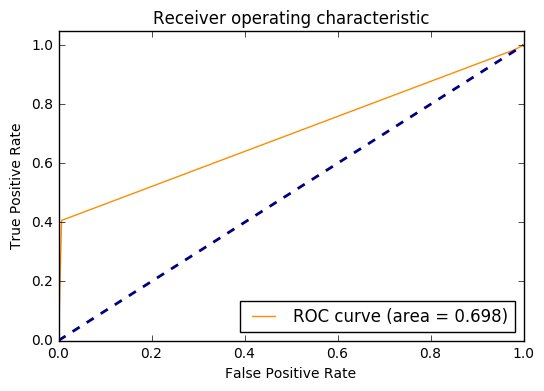

In [11]:
#ROC UNTUK CV___>PAKAI DATA TRAINING
from sklearn.metrics import precision_recall_curve,roc_curve,auc
from sklearn.cross_validation import *
#predicted = clf.predict(X_new_tfidf.toarray())
#predicted=cross_validation.cross_val_predict(lr, x, y, cv=kf_total, n_jobs = 1)
predicted=clf.predict(X_test)


y_uji=np.array(predicted)
y_asli=np.array(y_test)

y_asli[y_asli=='neg']=-1
y_asli[y_asli=='pos']=1
y_asli[y_asli=='net']=0


y_uji[y_uji=='neg']=-1
y_uji[y_uji=='pos']=1
y_uji[y_uji=='net']=0

y_uji=map(int, y_uji)
y_asli=map(int, y_asli)


n_classes=3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_asli,y_uji,pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_asli, y_uji,pos_label=1)
roc_auc = auc(fpr, tpr)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# SMOTE

In [12]:
sm = SMOTE(k=3)
X_res, y_res = sm.fit_sample(X_train_tfidf.toarray(), datatrain['sentiment'])
X_res, y_res=sm.fit_sample(X_res,y_res)
print ('Data sentmen asli {}'.format (Counter(datatrain['sentiment'])))
print('Resampled dataset shape {}'.format(Counter(y_res)))

clf=xgboost.XGBClassifier()
#clf = svm.SVC(decision_function_shape='ovo')
X_train, X_test, y_train, y_test = tts(X_res, y_res,test_size=0.2)
clf.fit(X_train,y_train)
predicted=clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))
presisi_svm_smote=metrics.precision_score(y_test, predicted,average='macro')
recall_svm_smote=metrics.recall_score(y_test, predicted,average='macro')
f1_svm_smote=metrics.f1_score(y_test, predicted,average='macro')
akurasi_svm_smote=metrics.accuracy_score(y_test, predicted)
print "Presisi:",presisi_svm_smote 
print "Recall:", recall_svm_smote
print "F1-Score:", f1_svm_smote
print "Akurasi:", akurasi_svm_smote



Data sentmen asli Counter({'net': 3887, 'neg': 598, 'pos': 315})
Resampled dataset shape Counter({'neg': 3887, 'net': 3887, 'pos': 3887})
             precision    recall  f1-score   support

        neg       0.86      0.88      0.87       794
        net       0.83      0.82      0.83       786
        pos       0.93      0.93      0.93       753

avg / total       0.87      0.87      0.87      2333

Presisi: 0.874426583638
Recall: 0.874267661878
F1-Score: 0.874301201632
Akurasi: 0.873553364766


In [13]:
#x=X_train_tfidf.toarray()
#y=datatrain['sentiment']
from sklearn import datasets, linear_model, cross_validation, grid_search
x=X_res
y=y_res
lr =svm.LinearSVC() 
kf_total = KFold(len(x), n_folds=10, shuffle=True, random_state=4)
scores_xgb_kfold=cross_validation.cross_val_score(lr, x, y, cv=kf_total, n_jobs = 1)
print scores_xgb_kfold
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_xgb_kfold.mean(), scores_xgb_kfold.std() * 2))


[ 0.96401028  0.96569468  0.96226415  0.94168096  0.96226415  0.93996569
  0.94596913  0.95540309  0.95540309  0.95626072]
Accuracy: 0.95 (+/- 0.02)
